cool to mcool

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler zoomify -r 100000,80000,60000,40000,20000 20250708_PnMs_merged.filtCisTrans.ImportantChrom.cool



In [ ]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cooler

# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
import os

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-v0_8-poster')
import numpy as np
import pandas as pd
from multiprocessing import Pool

# import open2c libraries
import bioframe

import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorial relies on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

# count cpus
num_cpus = os.getenv('SLURM_CPUS_PER_TASK')
if not num_cpus:
    num_cpus = os.cpu_count()
num_cpus = int(num_cpus)

In [4]:
import cooltools
data_dir = '/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/'
cool_file = "20250708_PnMs_merged.filtCisTrans.ImportantChrom.mcool"

cool_file = os.path.join(data_dir, cool_file)
print(cool_file)

/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250708_PnMs_merged.filtCisTrans.ImportantChrom.mcool


In [5]:
cooler.fileops.list_coolers(f'{data_dir}/20250708_PnMs_merged.filtCisTrans.ImportantChrom.mcool')

['/resolutions/20000',
 '/resolutions/40000',
 '/resolutions/60000',
 '/resolutions/80000',
 '/resolutions/100000']

In [6]:
### to load a cooler with a specific resolution use the following syntax:
clr = cooler.Cooler(f'{data_dir}/20250708_PnMs_merged.filtCisTrans.ImportantChrom.mcool::resolutions/100000')

### to print chromosomes and binsize for this cooler
print(f'chromosomes: {clr.chromnames}, binsize: {clr.binsize}')

### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

chromosomes: ['2L_mat', '2L_pat', '2L_trans', '2R_mat', '2R_pat', '2R_trans', '3L_mat', '3L_pat', '3L_trans', '3R_mat', '3R_pat', '3R_trans'], binsize: 100000
2L_mat : (0, 236)
2L_pat : (236, 472)
2L_trans : (472, 708)
2R_mat : (708, 961)
2R_pat : (961, 1214)
2R_trans : (1214, 1467)
3L_mat : (1467, 1749)
3L_pat : (1749, 2031)
3L_trans : (2031, 2313)
3R_mat : (2313, 2634)
3R_pat : (2634, 2955)
3R_trans : (2955, 3276)


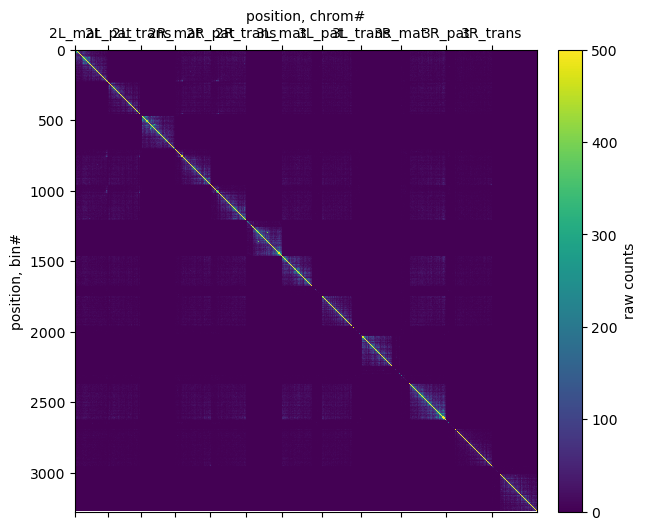

In [7]:
f, ax = plt.subplots(
    figsize=(7,6))
im = ax.matshow((clr.matrix(balance=False)[:]),vmax=500);
plt.colorbar(im ,fraction=0.046, pad=0.04, label='raw counts')
ax.set(xticks=chromstarts, xticklabels=clr.chromnames,
       xlabel='position, chrom#', ylabel='position, bin#')
ax.xaxis.set_label_position('top')

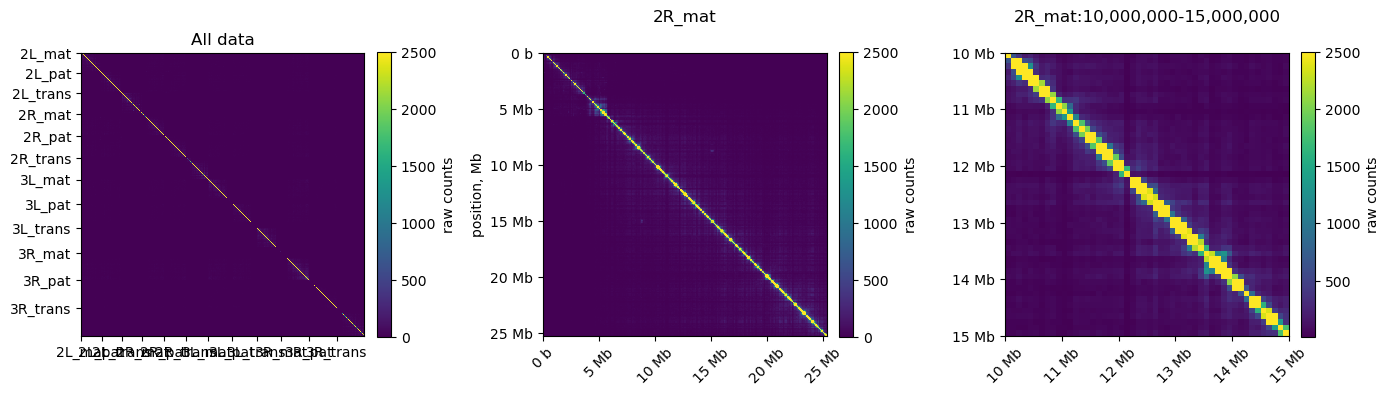

In [8]:
# to plot ticks in terms of megabases we use the EngFormatter
# https://matplotlib.org/gallery/api/engineering_formatter.html
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

f, axs = plt.subplots(
    figsize=(14,4),
    ncols=3)

ax = axs[0]
im = ax.matshow(clr.matrix(balance=False)[:], vmax=2500);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_xticks(chromstarts)
ax.set_xticklabels(clr.chromnames)
ax.set_yticks(chromstarts)
ax.set_yticklabels(clr.chromnames)
ax.xaxis.tick_bottom()
ax.set_title('All data')

ax = axs[1]
im = ax.matshow(
    clr.matrix(balance=False).fetch('2R_mat'),
    vmax=2500,
    extent=(0,clr.chromsizes['2R_mat'], clr.chromsizes['2R_mat'], 0)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title('2R_mat', y=1.08)
ax.set_ylabel('position, Mb')
format_ticks(ax)

ax = axs[2]
start, end = 10_000_000, 15_000_000
region = ('2R_mat', start, end)
im = ax.matshow(
    clr.matrix(balance=False).fetch(region),
    vmax=2500,
    extent=(start, end, end, start)
);
ax.set_title(f'2R_mat:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
format_ticks(ax)
plt.tight_layout()

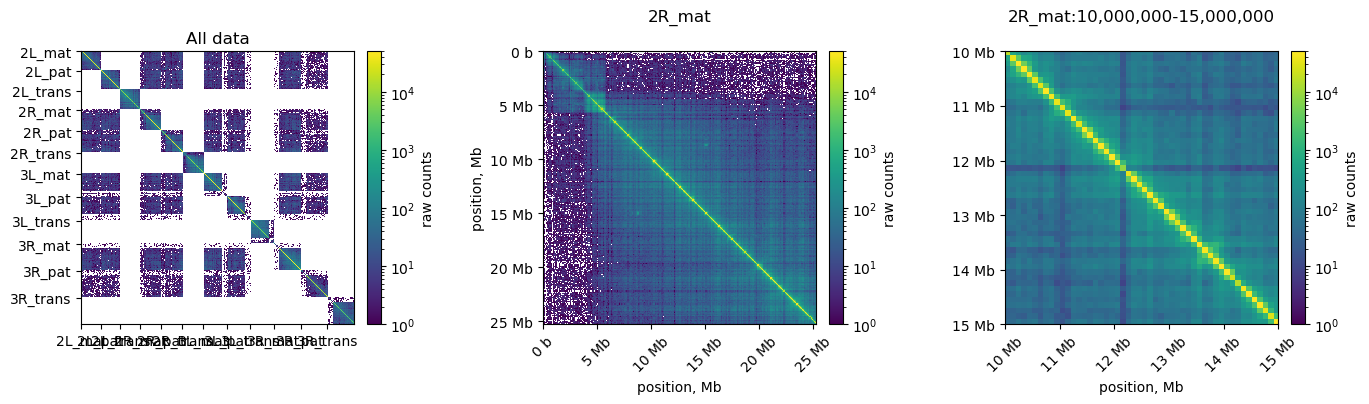

In [9]:
# plot heatmaps at megabase resolution with 3 levels of zoom in log-scale with a consistent colormap#
from matplotlib.colors import LogNorm

f, axs = plt.subplots(
    figsize=(14,4),
    ncols=3)
bp_formatter = EngFormatter('b')
norm = LogNorm(vmax=50_000)

ax = axs[0]
im = ax.matshow(
    clr.matrix(balance=False)[:],
    norm=norm,
)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_xticks(chromstarts)
ax.set_xticklabels(clr.chromnames)
ax.set_yticks(chromstarts)
ax.set_yticklabels(clr.chromnames)
ax.xaxis.tick_bottom()
ax.set_title('All data')

ax = axs[1]
im = ax.matshow(
    clr.matrix(balance=False).fetch('2R_mat'),
    norm=norm,
    extent=(0,clr.chromsizes['2R_mat'], clr.chromsizes['2R_mat'], 0)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title('2R_mat', y=1.08)
ax.set(ylabel='position, Mb', xlabel='position, Mb')
format_ticks(ax)

ax = axs[2]
start, end = 10_000_000, 15_000_000
region = ('2R_mat', start, end)
im = ax.matshow(
    clr.matrix(balance=False).fetch(region),
    norm=norm,
    extent=(start, end, end, start)
);
ax.set_title(f'2R_mat:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set(xlabel='position, Mb')
format_ticks(ax)
plt.tight_layout()

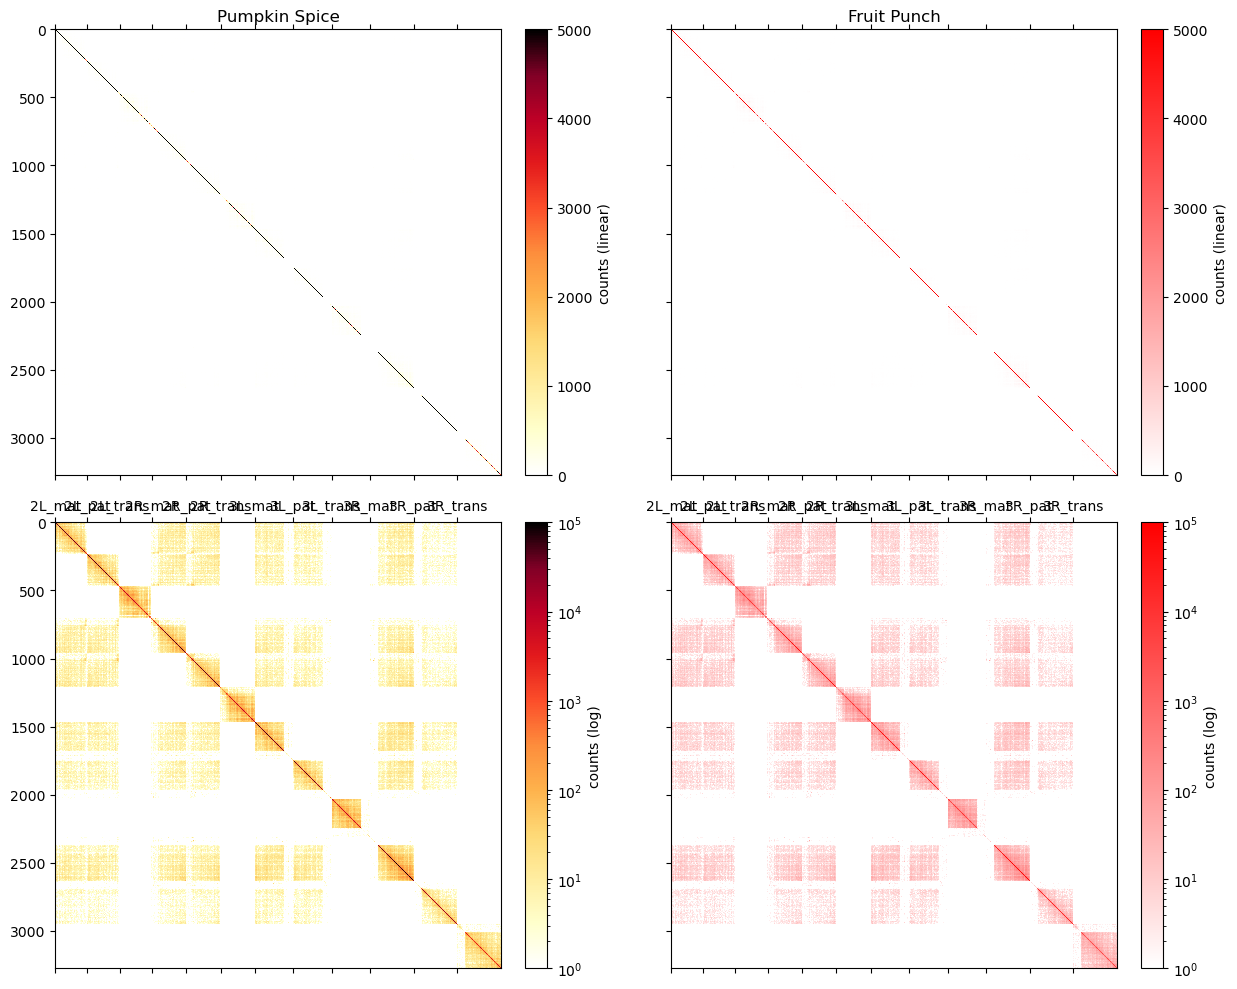

In [10]:
import cooltools.lib.plotting

vmax = 5000
norm = LogNorm(vmin=1, vmax=100_000)
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

f, axs = plt.subplots(
    figsize=(13, 10),
    nrows=2,
    ncols=2,
    sharex=True, sharey=True)

ax = axs[0, 0]
ax.set_title('Pumpkin Spice')
im = ax.matshow(clr.matrix(balance=False)[:], vmax=vmax, cmap='fall');
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts (linear)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[0, 1]
ax.set_title('Fruit Punch')
im3 = ax.matshow(clr.matrix(balance=False)[:], vmax=vmax, cmap=fruitpunch);
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='counts (linear)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[1, 0]
im = ax.matshow(clr.matrix(balance=False)[:], norm=norm, cmap='fall');
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts (log)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[1, 1]
im3 = ax.matshow(clr.matrix(balance=False)[:], norm=norm, cmap=fruitpunch);
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='counts (log)');
plt.xticks(chromstarts,clr.chromnames);

plt.tight_layout()

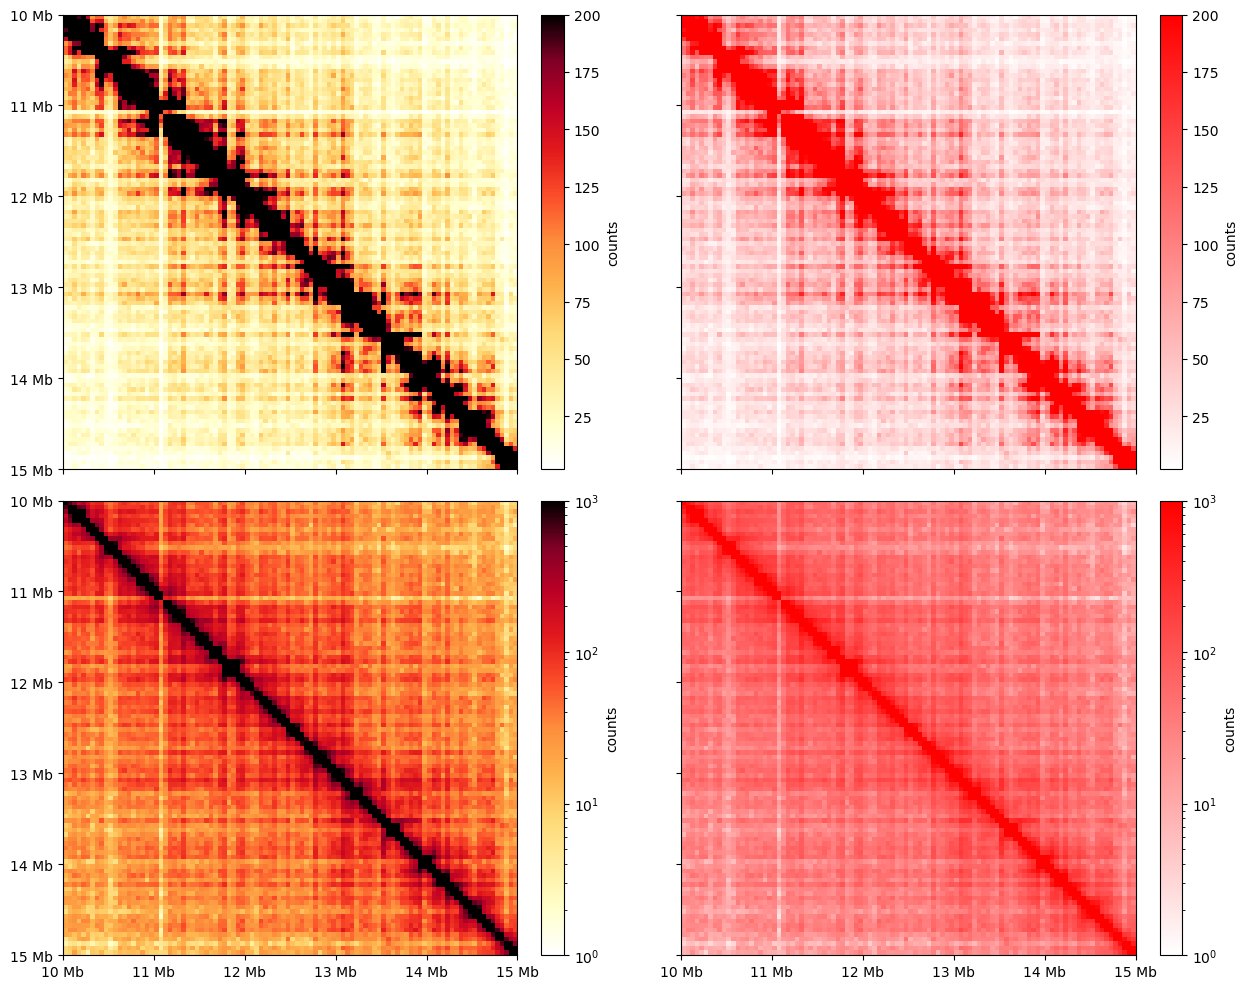

In [11]:
### plot the corrected data in fall heatmap ###
import cooltools.lib.plotting
clr_10kb = cooler.Cooler(f'{data_dir}/20250708_PnMs_merged.filtCisTrans.ImportantChrom.mcool::resolutions/100000')


region = '2R_mat:10,000,000-20,000,000'
extents = (start, end, end, start)
norm = LogNorm(vmin=1, vmax=1000)

f, axs = plt.subplots(
    figsize=(13, 10),
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True
)

ax = axs[0, 0]
im = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap='fall',
    vmax=200,
    extent=extents
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts');

ax = axs[0, 1]
im2 = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap=fruitpunch,
    vmax=200,
    extent=extents
);
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='counts');

ax = axs[1, 0]
im = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap='fall',
    norm=norm,
    extent=extents
);
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='counts');

ax = axs[1, 1]
im2 = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap=fruitpunch,
    norm=norm,
    extent=extents
);
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='counts');

for ax in axs.ravel():
    format_ticks(ax, rotate=False)
plt.tight_layout()


In [12]:
clr_10kb.bins()[:3]

,chrom,start,end
0,2L_mat,0,100000
1,2L_mat,100000,200000
2,2L_mat,200000,300000


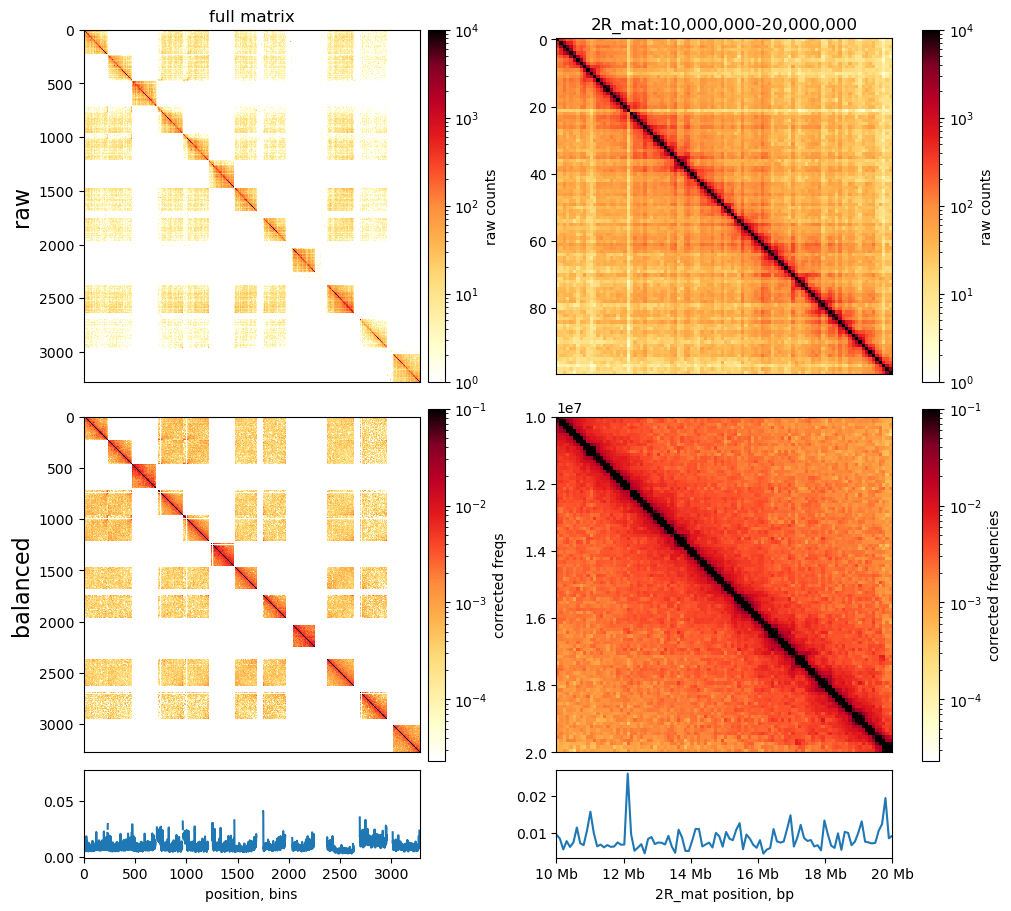

In [13]:
## plot the raw and corrected data in logscale ###
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt_width=4
f, axs = plt.subplots(
    figsize=( plt_width+plt_width+2, plt_width+plt_width+1),
    ncols=4,
    nrows=3,
    gridspec_kw={'height_ratios':[4,4,1],"wspace":0.01,'width_ratios':[1,.05,1,.05]},
    constrained_layout=True
)

norm = LogNorm(vmax=0.1)
norm_raw = LogNorm(vmin=1, vmax=10_000)

ax = axs[0,0]
im = ax.matshow(
    clr.matrix(balance=False)[:],
    norm=norm_raw,
    cmap='fall',
    aspect='auto'
);
ax.xaxis.set_visible(False)
ax.set_title('full matrix')
ax.set_ylabel('raw', fontsize=16)

cax = axs[0,1]
plt.colorbar(im, cax=cax, label='raw counts')

ax = axs[1,0]
im = ax.matshow(
    clr.matrix()[:],
    norm=norm,
    cmap='fall',
);
ax.xaxis.set_visible(False)
ax.set_ylabel('balanced', fontsize=16)

cax = axs[1,1]
plt.colorbar(im, cax=cax, label='corrected freqs')

ax1 = axs[2,0]
weights = clr.bins()[:]['weight'].values
ax1.plot(weights)
ax1.set_xlim([0, len(clr.bins()[:])])
ax1.set_xlabel('position, bins')

ax1 = axs[2,1]
ax1.set_visible(False)



start = 10_000_000
end = 20_000_000
region = ('2R_mat', start, end)

ax = axs[0,2]
im = ax.matshow(
        clr_10kb.matrix(balance=False).fetch(region),
    norm=norm_raw,
    cmap='fall'
);
ax.set_title(f'2R_mat:{start:,}-{end:,}')
ax.xaxis.set_visible(False)

cax = axs[0,3]
plt.colorbar(im, cax=cax, label='raw counts');

ax = axs[1,2]
im = ax.matshow(
    clr_10kb.matrix().fetch(region),
    norm=norm,
    cmap='fall',
    extent=(start, end, end, start)
);
ax.xaxis.set_visible(False)

cax = axs[1,3]
plt.colorbar(im, cax=cax, label='corrected frequencies');

ax1 = axs[2,2]
weights = clr_10kb.bins().fetch(region)['weight'].values
ax1.plot(
    np.linspace(start, end, len(weights)),
    weights
)
format_ticks(ax1, y=False, rotate=False)
ax1.set_xlim(start, end);
ax1.set_xlabel('2R_mat position, bp')

ax1 = axs[2,3]
ax1.set_visible(False)


coverage

Text(0, 0.5, 'coverage ratio')

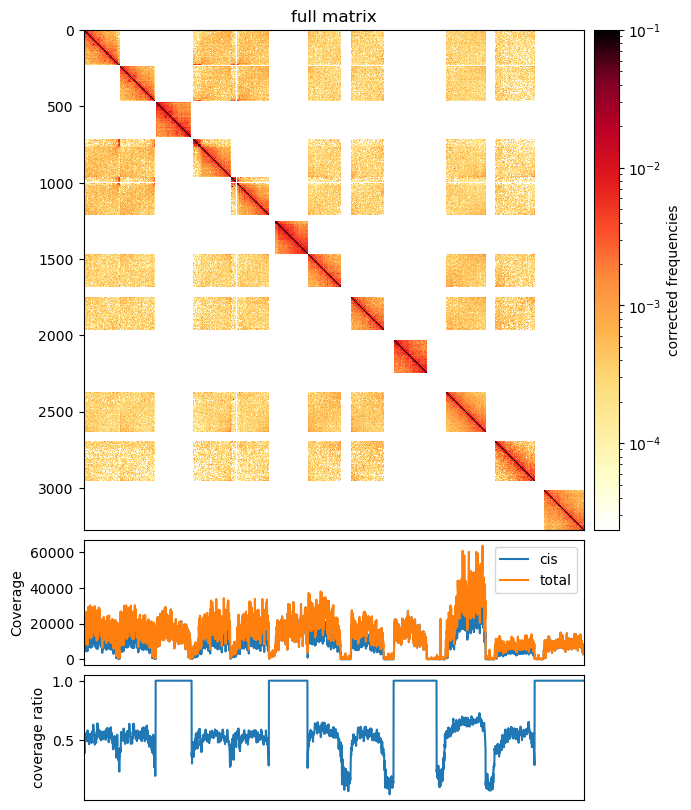

In [14]:
cis_coverage, tot_coverage = cooltools.coverage(clr)

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix()[:],
    norm=norm,
    cmap='fall'
);
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_title('full matrix')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
weights = clr.bins()[:]['weight'].values
ax1.plot( cis_coverage, label='cis')
ax1.plot( tot_coverage, label='total')
ax1.set_xlim([0, len(clr.bins()[:])])
ax1.set_ylabel('Coverage')
ax1.legend()
ax1.set_xticks([])

ax2 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
ax2.plot( cis_coverage/ tot_coverage)
ax2.set_xlim([0, len(clr.bins()[:])])
ax2.set_ylabel('coverage ratio')

Contact vs distance

In [25]:
chromsizes = pd.read_csv('/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.CisTrans.chromsizes', sep='\t')
clr = cooler.Cooler(f'{data_dir}/20250708_PnMs_merged.filtCisTrans.ImportantChrom.mcool::resolutions/100000')
#clr = cooler.Cooler(f'{data_dir}/20250708_PnMs_merged.filtCisTrans.ImportantChrom.mcool::resolutions/20000')
clr.bins()[:3]

,chrom,start,end,weight
0,2L_mat,0,100000,0.010353
1,2L_mat,100000,200000,0.020290
2,2L_mat,200000,300000,0.018080


In [39]:
chrom_df = pd.read_csv("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.CisTrans.chromsizes.view_df", sep='\t')
# cvd == contacts-vs-distance
cvd = cooltools.expected_cis(
    clr=clr,
    view_df=chrom_df,
    smooth=False,
    aggregate_smoothed=False,
    nproc=2 
)
chrom_df

INFO:root:creating a Pool of 2 workers


,chrom,start,end,name
0,2L_mat,0,23513712,2L_mat
1,2L_pat,0,23513712,2L_pat
2,2L_trans,0,23513712,2L_trans
3,2R_mat,0,25286936,2R_mat
4,2R_pat,0,25286936,2R_pat
5,2R_trans,0,25286936,2R_trans
6,3L_mat,0,28110227,3L_mat
7,3L_pat,0,28110227,3L_pat
8,3L_trans,0,28110227,3L_trans
9,3R_mat,0,32079331,3R_mat


In [27]:
display(cvd.head(4))
display(cvd.tail(4))

,region1,region2,dist,dist_bp,contact_frequency,n_total,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,2L_mat,2L_mat,0,0,NaN,236,231,NaN,NaN,NaN,NaN
1,2L_mat,2L_mat,1,100000,NaN,235,227,NaN,NaN,NaN,NaN
2,2L_mat,2L_mat,2,200000,0.038609,234,225,126160.0,8.687091,539.145299,0.038609
3,2L_mat,2L_mat,3,300000,0.020860,233,226,69949.0,4.714294,300.210300,0.020860


,region1,region2,dist,dist_bp,contact_frequency,n_total,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
3272,3R_trans,3R_trans,317,31700000,NaN,4,0,0.0,0.0,0.0,NaN
3273,3R_trans,3R_trans,318,31800000,NaN,3,0,0.0,0.0,0.0,NaN
3274,3R_trans,3R_trans,319,31900000,NaN,2,0,0.0,0.0,0.0,NaN
3275,3R_trans,3R_trans,320,32000000,NaN,1,0,0.0,0.0,0.0,NaN


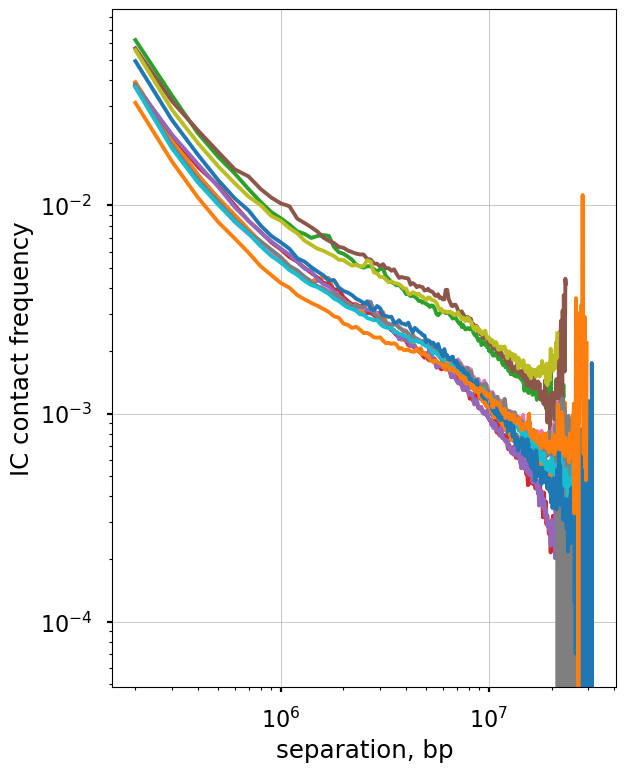

In [29]:
f, ax = plt.subplots(1,1)

for region in chrom_df['name']:
    ax.loglog(
        cvd['dist_bp'].loc[cvd['region1']==region],
        cvd['contact_frequency'].loc[cvd['region1']==region],
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

Smoothing & aggregating P(s) curves

In [31]:
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=chrom_df,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=num_cpus
)

INFO:root:creating a Pool of 64 workers


In [32]:
display(cvd_smooth_agg.head(4))

,region1,region2,dist,dist_bp,contact_frequency,n_total,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,2L_mat,2L_mat,0,0,NaN,236,231,NaN,NaN,NaN,NaN,NaN,NaN
1,2L_mat,2L_mat,1,100000,0.000458,235,227,NaN,NaN,NaN,NaN,0.000408,0.000458
2,2L_mat,2L_mat,2,200000,0.039074,234,225,126160.0,8.687091,539.145299,0.038609,0.034983,0.039074
3,2L_mat,2L_mat,3,300000,0.023013,233,226,69949.0,4.714294,300.210300,0.020860,0.020626,0.023013


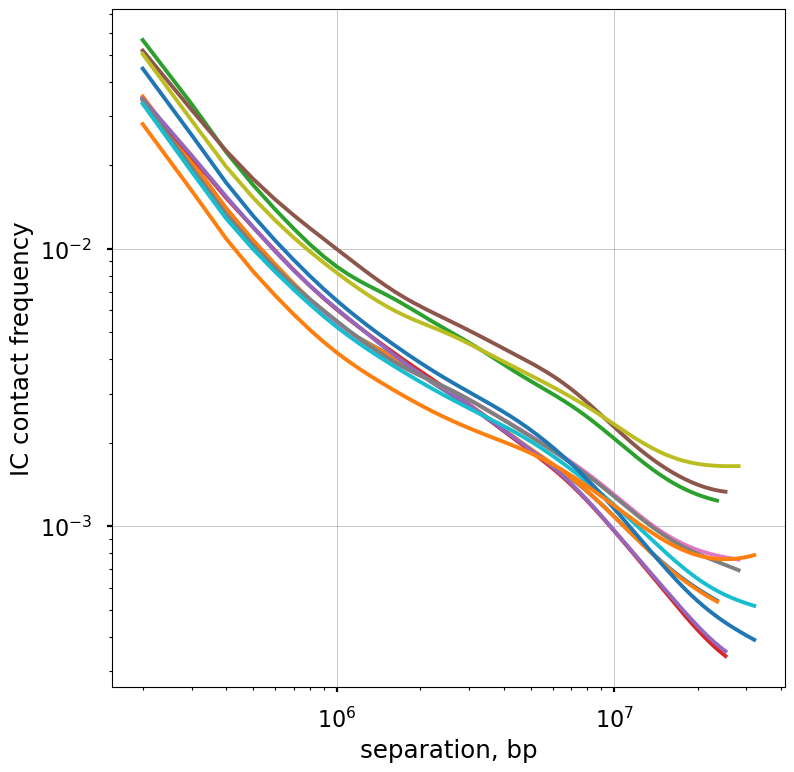

In [34]:
cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['dist'] < 2] = np.nan

f, ax = plt.subplots(1,1)

for region in chrom_df['name']:
    ax.loglog(
        cvd_smooth_agg['dist_bp'].loc[cvd_smooth_agg['region1']==region],
        cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['region1']==region],
    )
    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)